In [1]:
import os
import sys
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
sys.path.append("../../Utils")
from loaders import HNSCCFeatureHandler

METADATA_PATH = "../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW_v8.csv"
VALID_IDS_PATH = "../../Utils/Lists/cv_ids.txt"
HOLD_IDS_PATH = '../../Utils/Lists/holdout_ids.txt'

hc_data = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH, HOLD_IDS_PATH)
_ = hc_data.load_feature_to_dataframe("../../Data/*.hg38.frag.interval_mds.tsv", 0, 4)
z = hc_data.normalize_zscore()
_ = hc_data.merge_feature_metadata()
z = hc_data.batch_correct()

with open('predicted_treatment_response_dict.pkl', 'rb') as f:
    predicted = pickle.load(f)

with open('treatment_response_dict.pkl', 'rb') as f:
    truth = pickle.load(f)

with open('tumor_fraction_from_median.pkl', 'rb') as f:
    tumor = pickle.load(f)

In [2]:
s = hc_data.get_metadata_col('Patient Number', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
switched_df = s.reset_index().drop_duplicates(subset='Patient Number', keep='first')
switched = switched_df.set_index('Patient Number')['index']

In [3]:
predicted = {switched.get(k, k): v for k, v in predicted.items()}
tumor = {switched.get(k, k): v for k, v in tumor.items()}

In [4]:
# Load all survival and relapse columns
relapse_surg = hc_data.get_metadata_col('Relapse Months (Surgery)', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
relapse_adj = hc_data.get_metadata_col('Relapse Months (Adjuvant)', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))

surv_surg = hc_data.get_metadata_col('Survival Months (Surgery)', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
surv_adj = hc_data.get_metadata_col('Survival Months (Adjuvant)', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))

relapse_status = hc_data.get_metadata_col('E_Relapse', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0)).astype(bool)
surv_status = hc_data.get_metadata_col('E_Survival', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0)).astype(bool)

treatment_response = hc_data.get_metadata_col('Stratification', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
truth_response = hc_data.get_metadata_col('Treatment Response', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
resp_category = hc_data.get_metadata_col('Response Rate Categorized', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))

patient_number = hc_data.get_metadata_col('Patient Number', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
diagnosis = hc_data.get_metadata_col('Diagnosis', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
age = hc_data.get_metadata_col('Age', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
gender = hc_data.get_metadata_col('Gender', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
smoking = hc_data.get_metadata_col('Smoking', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
alcohol = hc_data.get_metadata_col('Alcohol', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
race = hc_data.get_metadata_col('Race', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
ethnicity = hc_data.get_metadata_col('Ethnicity', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
hpv = hc_data.get_metadata_col('HPV', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
pdl1_ihc = hc_data.get_metadata_col('PDL1 IHC', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0)).replace({0: "0", 1: "1-19", 2: ">20"})

keep_idx = list(predicted.keys())
cols_to_filter = [
    relapse_surg, relapse_adj,
    surv_surg,  surv_adj,
    relapse_status, surv_status, treatment_response, truth_response, resp_category,
    patient_number, diagnosis, age, gender, smoking, alcohol, hpv, race, ethnicity, pdl1_ihc
]

filtered_cols = [col[col.index.isin(keep_idx)] for col in cols_to_filter]
(
    relapse_surg, relapse_adj,
    surv_surg, surv_adj,
    relapse_status, surv_status, treatment_response, truth_response, resp_category,
    patient_number, diagnosis, age, gender, smoking, alcohol, hpv, race, ethnicity, pdl1_ihc
) = filtered_cols

# Create merged DataFrame
merged_df = pd.concat([
    surv_surg,  surv_adj, 
    relapse_surg, relapse_adj,
    surv_status, relapse_status,
    treatment_response, patient_number, diagnosis, age, gender,
    smoking, alcohol, hpv, race, ethnicity, pdl1_ihc,
    truth_response, resp_category
], axis=1)

merged_df.columns = [
    'Survival Months (Surgery)',  'Survival Months (Adjuvant)',
    'Relapse Months (Surgery)', 'Relapse Months (Adjuvant)',
    'E_Survival', 'E_Relapse',
    'Stratification', 'Patient Number', 'Diagnosis', 'Age', 'Gender',
    'Smoking', 'Alcohol', 'HPV', 'Race', 'Ethnicity', 'PDL1 IHC',
    'Actual Treatment Response', 'Response Category'
]

# Add predictions and tumor fractions
merged_df['Predicted Treatment Response'] = merged_df.index.map(predicted)
merged_df['Tumor Fraction'] = merged_df.index.map(tumor)


In [5]:
merged_df = merged_df[merged_df['Relapse Months (Adjuvant)'].notna()]

In [21]:
# merged_df["Actual Treatment Response with Stratification"] = (
#     merged_df["Actual Treatment Response"].astype(str) + "_" + merged_df["Stratification"].astype(str)
# )

In [25]:
# merged_df["Predicted Treatment Response with Stratification"] = (
#     merged_df["Predicted Treatment Response"].astype(str) + "_" + merged_df["Stratification"].astype(str)
# )

In [26]:
# merged_df["IHC with Stratification"] = (
#     merged_df["PDL1 IHC"].astype(str) + "_" + merged_df["Stratification"].astype(str)
# )

In [27]:
# merged_df["Tumor Fraction with Stratification"] = (
#     merged_df["Tumor Fraction"].astype(str) + "_" + merged_df["Stratification"].astype(str)
# )

In [6]:
def get_mean_y_score_by_patient(csv_path):
    df = pd.read_csv(csv_path)
    patient_scores = {}

    for _, row in df.iterrows():
        # Parse scores and patient IDs
        y_score = [float(x) for x in row['probs'].strip("[]").replace('\n', ' ').split(',') if x]
        patient_list = [int(float(x)) for x in row['patients'].strip("[]").replace('\n', ' ').split(',') if x]

        for patient, score in zip(patient_list, y_score):
            patient_scores.setdefault(patient, []).append(score)

    # Compute mean score per patient
    mean_scores = {patient: np.mean(scores) for patient, scores in patient_scores.items()}
    return mean_scores

In [7]:
repinst_probabilities = get_mean_y_score_by_patient("../../Main_Figures/F4/MDS_Patient_Probabilities.csv")
merged_df['REPINST_Probabilities'] = merged_df['Patient Number'].map(repinst_probabilities)

merged_df['REPINST_Predictions'] = merged_df['REPINST_Probabilities'].apply(
    lambda x: 'Responder' if x > 0.5 else 'Non-Responder'
)

rephold_probabilities = get_mean_y_score_by_patient("../../Main_Figures/F4/MDS_Holdout_Patient_Probabilities.csv")
merged_df['REPHOLD_Probabilities'] = merged_df['Patient Number'].map(rephold_probabilities)

merged_df['REPHOLD_Predictions'] = merged_df['REPHOLD_Probabilities'].apply(
    lambda x: 'Responder' if x > 0.5 else 'Non-Responder'
)

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
merged_df

,Survival Months (Surgery),Survival Months (Adjuvant),Relapse Months (Surgery),Relapse Months (Adjuvant),E_Survival,E_Relapse,Stratification,Patient Number,Diagnosis,Age,Gender,Smoking,Alcohol,HPV,Race,Ethnicity,PDL1 IHC,Actual Treatment Response,Response Category,Predicted Treatment Response,Tumor Fraction,REPINST_Probabilities,REPINST_Predictions,REPHOLD_Probabilities,REPHOLD_Predictions
Pilot2_3,19.290323,18.033333,11.645161,10.400000,True,True,High,1.0,Oral Cavity,44.0,Female,Yes,No,Unknown,White,Non-Hispanic,1-19,Non-Responder,0.0,Non-Responder,Low Tumor Fraction,0.409145,Non-Responder,0.678774,Responder
Pilot2_6,4.866667,3.225806,3.066667,1.451613,True,True,High,2.0,Oral Cavity,51.0,Male,No,No,Unknown,White,Non-Hispanic,1-19,Responder,1.0,Responder,Low Tumor Fraction,0.403700,Non-Responder,0.454004,Non-Responder
Pilot2_9,55.066667,54.000000,55.066667,54.000000,False,False,High,3.0,Oral Cavity,71.0,Female,Yes,No,Unknown,White,Non-Hispanic,1-19,Responder,1.0,Responder,High Tumor Fraction,0.435823,Non-Responder,0.635519,Responder
Pilot2_14,23.161290,22.064516,9.806452,8.709677,True,True,High,5.0,Oral Cavity,70.0,Female,No,No,Unknown,White,Non-Hispanic,1-19,Non-Responder,0.0,Non-Responder,Low Tumor Fraction,0.304299,Non-Responder,0.578612,Responder
Pilot2_16,30.709677,29.366667,12.096774,10.733333,False,True,Intermediate,6.0,Oral Cavity,55.0,Male,Yes,Yes,Unknown,White,Non-Hispanic,0,Non-Responder,0.0,Non-Responder,High Tumor Fraction,0.019203,Non-Responder,0.354893,Non-Responder
Pilot2_19,12.129032,11.064516,11.451613,10.387097,True,True,High,7.0,Oral Cavity,49.0,Male,Yes,No,Unknown,White,Non-Hispanic,0,Responder,3.0,Responder,High Tumor Fraction,0.717584,Responder,0.374382,Non-Responder
Pilot2_22,69.433333,67.774194,69.433333,67.774194,False,False,High,8.0,Oral Cavity,38.0,Female,Yes,No,No,White,Non-Hispanic,0,Non-Responder,0.0,Non-Responder,High Tumor Fraction,0.552440,Responder,0.724968,Responder
Pilot2_25,38.133333,37.032258,38.133333,37.032258,True,True,High,9.0,Larynx,63.0,Male,Yes,Yes,Unknown,White,Non-Hispanic,1-19,Responder,3.0,Responder,High Tumor Fraction,0.882819,Responder,0.221018,Non-Responder
Pilot2_28,23.806452,22.870968,23.806452,22.870968,True,True,High,10.0,Hypopharynx,49.0,Male,Yes,Yes,No,White,Non-Hispanic,0,Non-Responder,0.0,Non-Responder,High Tumor Fraction,0.211976,Non-Responder,0.301025,Non-Responder
Pilot2_30,64.387097,63.451613,64.387097,63.451613,False,False,Intermediate,11.0,Larynx,45.0,Male,Yes,Yes,Yes,White,Non-Hispanic,1-19,Non-Responder,0.0,Non-Responder,Low Tumor Fraction,0.582747,Responder,0.977383,Responder


In [9]:
merged_df.to_csv('survival_data.csv')

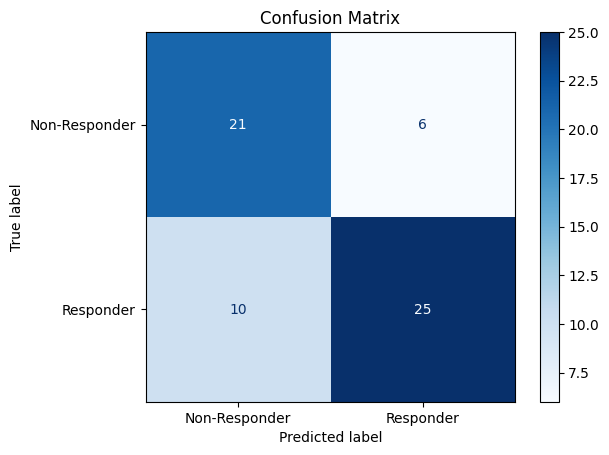

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Optional: convert to binary labels if not already (e.g., "Responder" → 1, "Non-Responder" → 0)
y_true = merged_df["Actual Treatment Response"].map({"Responder": 1, "Non-Responder": 0})
y_pred = merged_df["REPINST_Predictions"].map({"Responder": 1, "Non-Responder": 0})

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Responder", "Responder"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


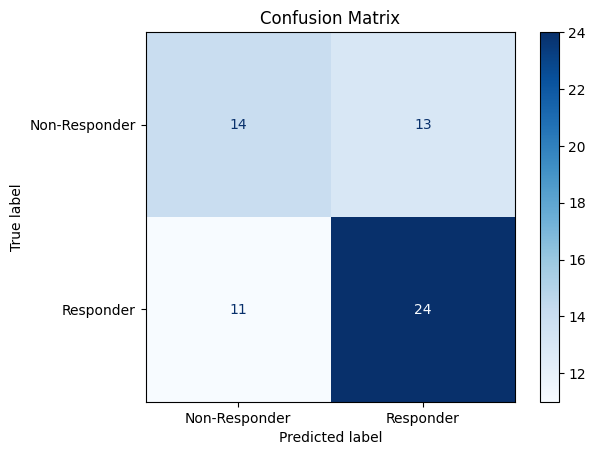

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Optional: convert to binary labels if not already (e.g., "Responder" → 1, "Non-Responder" → 0)
y_true = merged_df["Actual Treatment Response"].map({"Responder": 1, "Non-Responder": 0})
y_pred = merged_df["REPHOLD_Predictions"].map({"Responder": 1, "Non-Responder": 0})

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Responder", "Responder"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


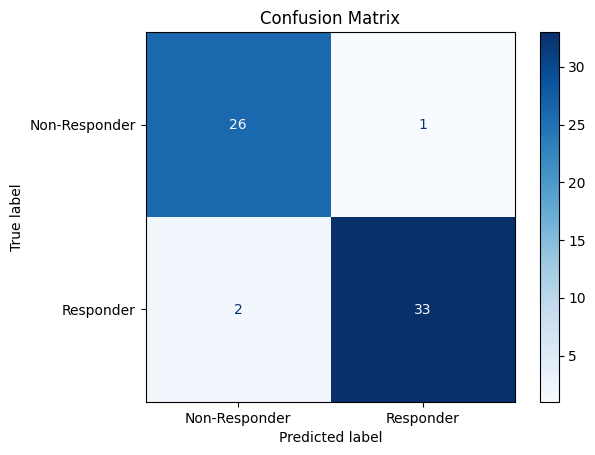

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Optional: convert to binary labels if not already (e.g., "Responder" → 1, "Non-Responder" → 0)
y_true = merged_df["Actual Treatment Response"].map({"Responder": 1, "Non-Responder": 0})
y_pred = merged_df["Predicted Treatment Response"].map({"Responder": 1, "Non-Responder": 0})

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Responder", "Responder"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
